# 🔄 Contrarian Commodities Trading System - MEAN REVERSION

Sistema quantitativo contrarian sulle commodities: short sui top N (migliori), long sui bottom N (peggiori).

**Strategia Contrarian:**
- Ribilanciamento settimanale ogni venerdì
- **Long sulle N peggiori (momentum negativo)**
- **Short sulle N migliori (momentum positivo)**
- Equal weight allocation
- Logica opposta rispetto alla strategia momentum

---

## 📦 Setup e Importazioni

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from core.commodity_momentum import (
    generate_equal_weighted_commodity_momentum_signals,
    generate_long_short_commodity_momentum_signals,
    calculate_portfolio_performance
)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
print('✅ Setup completato!')

✅ Setup completato!


## 📊 Caricamento Dati e Configurazione

In [2]:
df = pd.read_parquet('../data/commodities_extended_data.parquet')
lookback_days = 90
top_n = 3
rebalance_weekday = 4  # venerdì
print(f'✅ Dati caricati. Lookback: {lookback_days} giorni, top_n: {top_n}')

✅ Dati caricati. Lookback: 90 giorni, top_n: 3


## 🔄 Generazione Segnali Contrarian

In [3]:
# Genera segnali momentum long/short
signals_momentum = generate_long_short_commodity_momentum_signals(
    df, lookback_days=lookback_days, top_n=top_n, rebalance_weekday=rebalance_weekday
)
# Inverti la logica: long sui peggiori, short sui migliori
signals_contrarian = signals_momentum * -1

print('Segnali contrarian generati (logica invertita rispetto al momentum)!')

Segnali contrarian generati (logica invertita rispetto al momentum)!


## 🚀 Backtest Strategia Contrarian

In [4]:
equity_contrarian = calculate_portfolio_performance(signals_contrarian, df)

# Calcola statistiche complete
returns_contrarian = equity_contrarian.pct_change().fillna(0)

print(f'📊 PERFORMANCE STRATEGIA CONTRARIAN COMMODITIES')
print('='*55)
print(f'Periodo: {equity_contrarian.index[0].strftime("%Y-%m-%d")} → {equity_contrarian.index[-1].strftime("%Y-%m-%d")}')
print(f'Rendimento totale: {(equity_contrarian.iloc[-1] - 1) * 100:.1f}%')
print(f'Rendimento annualizzato: {((equity_contrarian.iloc[-1] ** (252 / len(equity_contrarian))) - 1) * 100:.1f}%')
print(f'Volatilità annua: {returns_contrarian.std() * np.sqrt(252) * 100:.1f}%')
print(f'Sharpe Ratio: {(returns_contrarian.mean() * 252) / (returns_contrarian.std() * np.sqrt(252)):.2f}')

# Drawdown
running_max = equity_contrarian.cummax()
drawdown = (equity_contrarian / running_max) - 1
print(f'Max Drawdown: {drawdown.min() * 100:.1f}%')
print('='*55)

📊 PERFORMANCE STRATEGIA CONTRARIAN COMMODITIES
Periodo: 2000-01-03 → 2025-08-04
Rendimento totale: 1999.4%
Rendimento annualizzato: 12.6%
Volatilità annua: 33.6%
Sharpe Ratio: 0.53
Max Drawdown: -62.3%


## 🔄 Confronto con Strategia Momentum

In [5]:
# Calcola performance strategia momentum per confronto
equity_momentum = calculate_portfolio_performance(signals_momentum, df)
returns_momentum = equity_momentum.pct_change().fillna(0)

print('📊 CONFRONTO MOMENTUM vs CONTRARIAN')
print('='*50)
print(f'{"METRICA":<25} {"MOMENTUM":<12} {"CONTRARIAN":<12}')
print('-'*50)

metrics = [
    ('Return Totale (%)', (equity_momentum.iloc[-1] - 1) * 100, (equity_contrarian.iloc[-1] - 1) * 100),
    ('Return Annuo (%)', ((equity_momentum.iloc[-1] ** (252 / len(equity_momentum))) - 1) * 100, 
     ((equity_contrarian.iloc[-1] ** (252 / len(equity_contrarian))) - 1) * 100),
    ('Volatilità (%)', returns_momentum.std() * np.sqrt(252) * 100, returns_contrarian.std() * np.sqrt(252) * 100),
    ('Sharpe Ratio', (returns_momentum.mean() * 252) / (returns_momentum.std() * np.sqrt(252)),
     (returns_contrarian.mean() * 252) / (returns_contrarian.std() * np.sqrt(252))),
    ('Max Drawdown (%)', ((equity_momentum / equity_momentum.cummax()) - 1).min() * 100,
     ((equity_contrarian / equity_contrarian.cummax()) - 1).min() * 100)
]

for metric, mom_val, con_val in metrics:
    print(f'{metric:<25} {mom_val:<12.1f} {con_val:<12.1f}')

print('='*50)
if equity_contrarian.iloc[-1] > equity_momentum.iloc[-1]:
    print('🎯 La strategia CONTRARIAN supera il MOMENTUM!')
else:
    print('📉 La strategia MOMENTUM supera il CONTRARIAN.')

📊 CONFRONTO MOMENTUM vs CONTRARIAN
METRICA                   MOMENTUM     CONTRARIAN  
--------------------------------------------------
Return Totale (%)         -99.8        1999.4      
Return Annuo (%)          -20.9        12.6        
Volatilità (%)            33.6         33.6        
Sharpe Ratio              -0.5         0.5         
Max Drawdown (%)          -99.8        -62.3       
🎯 La strategia CONTRARIAN supera il MOMENTUM!


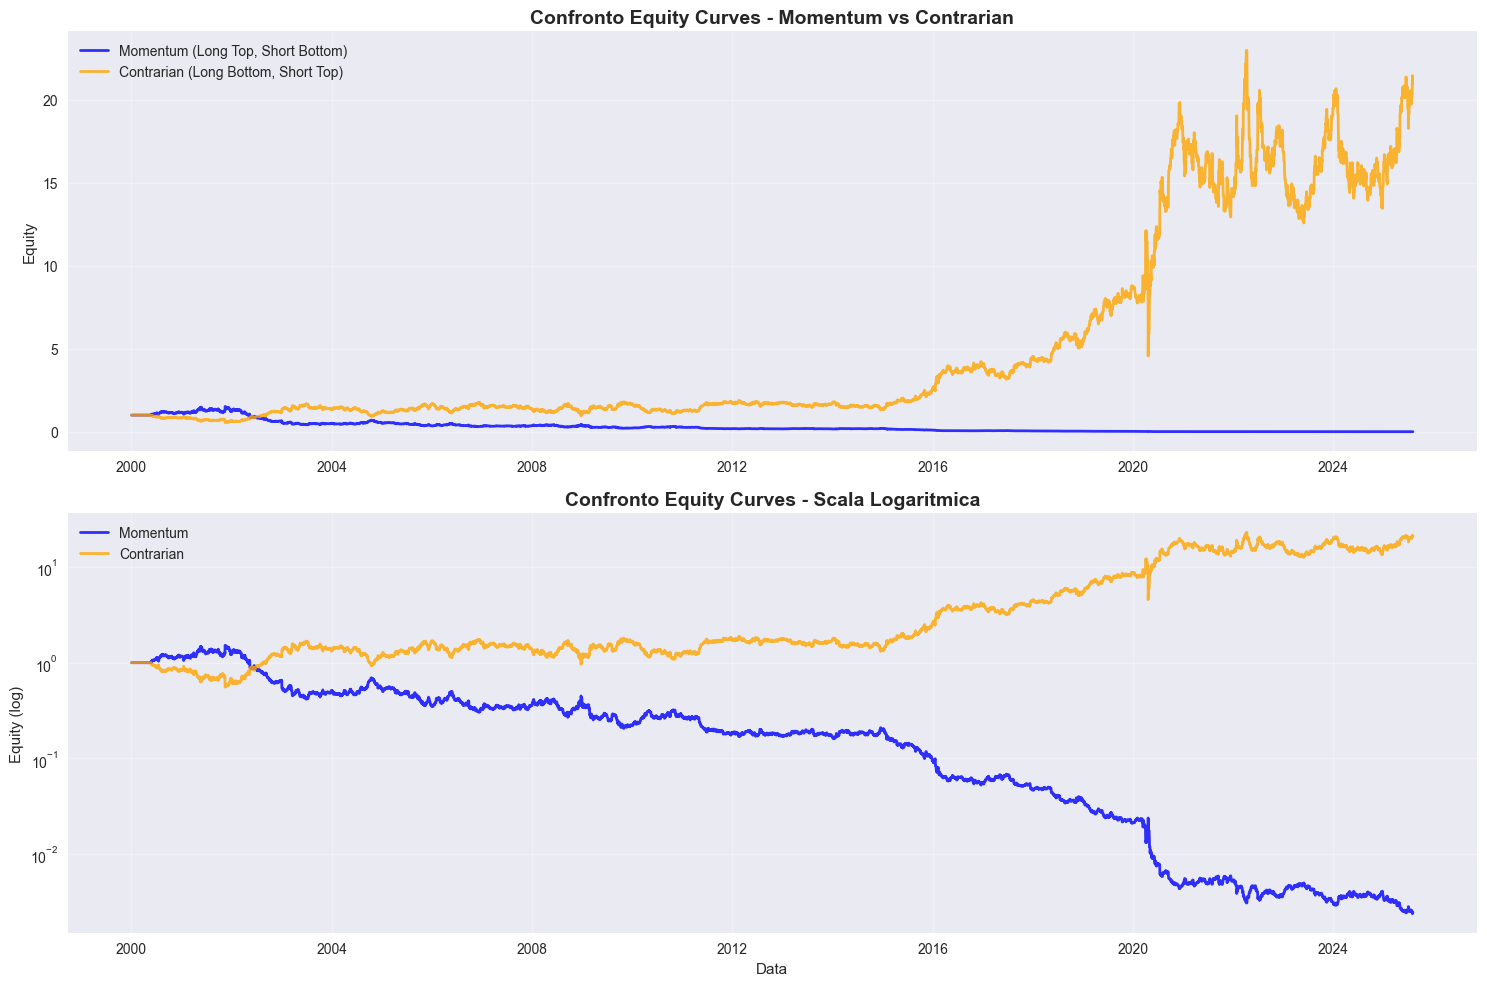

In [6]:
# Visualizzazione comparativa
plt.figure(figsize=(15, 10))

# Equity curves lineari
plt.subplot(2, 1, 1)
plt.plot(equity_momentum.index, equity_momentum.values, linewidth=2, color='blue', 
         label='Momentum (Long Top, Short Bottom)', alpha=0.8)
plt.plot(equity_contrarian.index, equity_contrarian.values, linewidth=2, color='orange', 
         label='Contrarian (Long Bottom, Short Top)', alpha=0.8)
plt.title('Confronto Equity Curves - Momentum vs Contrarian', fontsize=14, fontweight='bold')
plt.ylabel('Equity')
plt.legend()
plt.grid(True, alpha=0.3)

# Equity curves logaritmiche
plt.subplot(2, 1, 2)
plt.plot(equity_momentum.index, equity_momentum.values, linewidth=2, color='blue', 
         label='Momentum', alpha=0.8)
plt.plot(equity_contrarian.index, equity_contrarian.values, linewidth=2, color='orange', 
         label='Contrarian', alpha=0.8)
plt.yscale('log')
plt.title('Confronto Equity Curves - Scala Logaritmica', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Equity (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📈 Analisi Dettagliata Strategia Contrarian

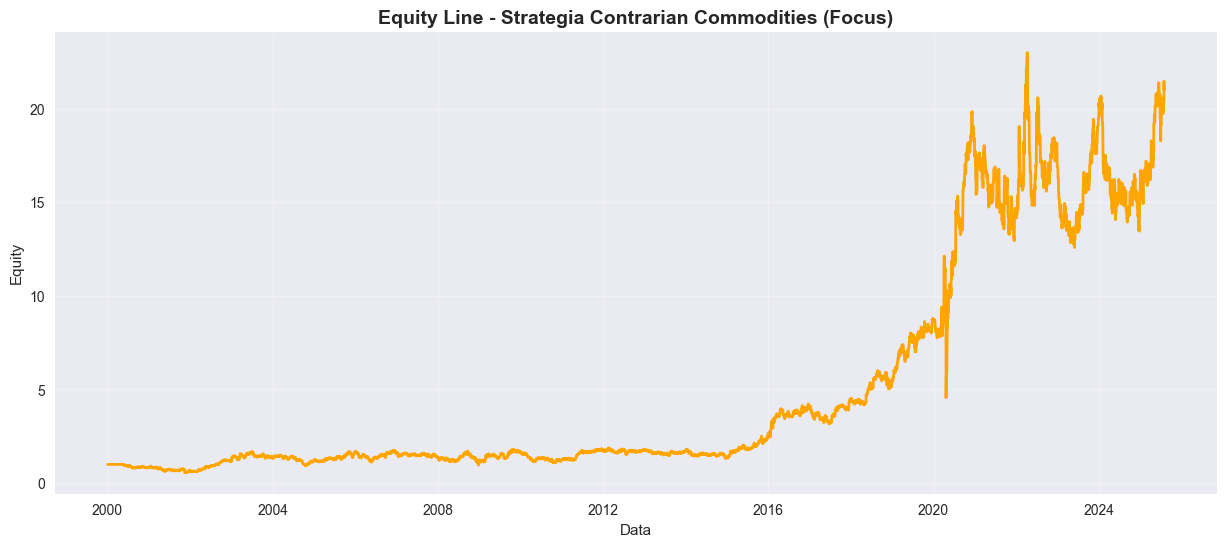

✅ Equity finale: 20.99 (rendimento: 1999.4%)


In [7]:
# Equity curve dettagliata strategia contrarian
plt.figure(figsize=(15, 6))
plt.plot(equity_contrarian.index, equity_contrarian.values, linewidth=2, color='orange')
plt.title('Equity Line - Strategia Contrarian Commodities (Focus)', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Equity')
plt.grid(True, alpha=0.3)
plt.show()

print(f'✅ Equity finale: {equity_contrarian.iloc[-1]:.2f} (rendimento: {(equity_contrarian.iloc[-1]-1)*100:.1f}%)')

## 📊 Analisi Drawdown

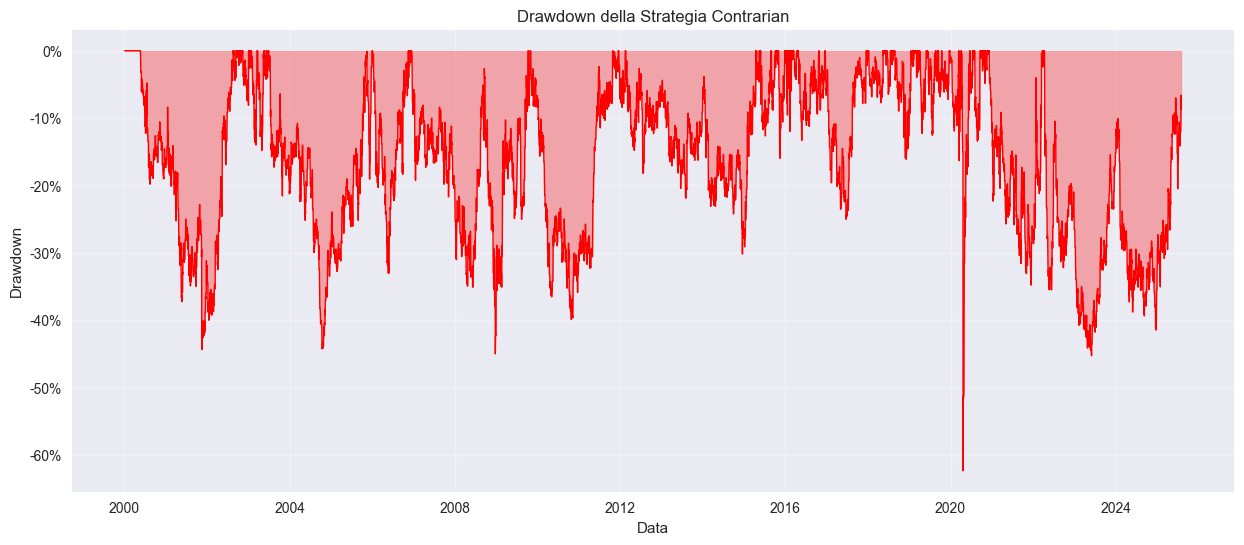

Top 5 Drawdown peggiori:
2020-04-21: -62.33%
2020-04-22: -54.62%
2020-04-23: -52.51%
2020-04-24: -51.30%
2020-04-27: -51.30%


In [8]:
running_max = equity_contrarian.cummax()
drawdown = (equity_contrarian / running_max) - 1
plt.figure(figsize=(15, 6))
plt.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
plt.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
plt.title('Drawdown della Strategia Contrarian')
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid(True, alpha=0.3)
plt.show()
print('Top 5 Drawdown peggiori:')
worst_drawdowns = drawdown.nsmallest(5)
for date, dd in worst_drawdowns.items():
    print(f'{date.strftime('%Y-%m-%d')}: {dd:.2%}')

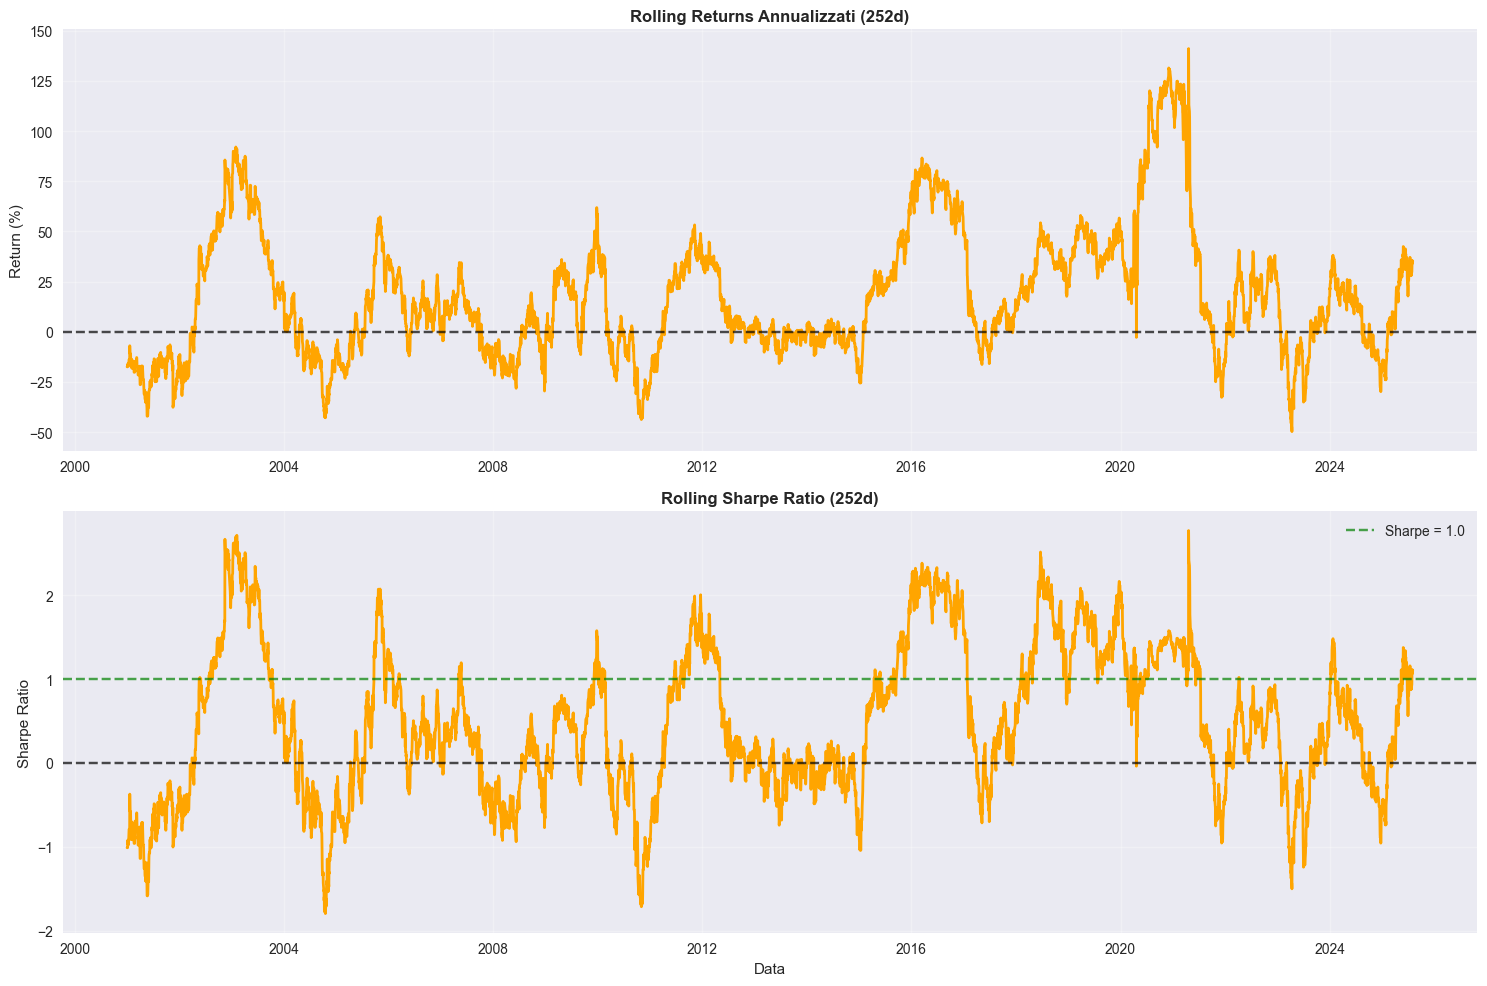


🎯 RIEPILOGO STRATEGIA CONTRARIAN COMMODITIES
• Lookback: 90 giorni
• Asset per gruppo: 3 (long bottom + short top)
• Logica: opposta al momentum (mean reversion)
• Rendimento totale: 1999.4%
• Rendimento annualizzato: 12.6%
• Sharpe Ratio: 0.53
• Max Drawdown: -62.3%
• File salvato: contrarian_commodities_90d.csv
✅ Analisi Contrarian Commodities completata!


In [9]:
# 📊 Analisi Rolling Performance e Salvataggio Risultati
window = 252  # 1 anno

rolling_ret = returns_contrarian.rolling(window).mean() * 252 * 100
rolling_vol = returns_contrarian.rolling(window).std() * np.sqrt(252) * 100
rolling_sharpe = rolling_ret / rolling_vol

# Visualizzazione rolling metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(rolling_ret.index, rolling_ret.values, color='orange', linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax1.set_title('Rolling Returns Annualizzati (252d)', fontweight='bold')
ax1.set_ylabel('Return (%)')
ax1.grid(True, alpha=0.3)

ax2.plot(rolling_sharpe.index, rolling_sharpe.values, color='orange', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
ax2.set_title('Rolling Sharpe Ratio (252d)', fontweight='bold')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 💾 Salvataggio risultati
contrarian_file = f'contrarian_commodities_{lookback_days}d.csv'
contrarian_df = pd.DataFrame({
    'Date': equity_contrarian.index,
    'Contrarian_Value': equity_contrarian.values,
    'Contrarian_Return': returns_contrarian.values
})
contrarian_df.to_csv(contrarian_file, index=False)

# 🎯 Riepilogo finale
print(f"\n🎯 RIEPILOGO STRATEGIA CONTRARIAN COMMODITIES")
print("="*55)
print(f"• Lookback: {lookback_days} giorni")  
print(f"• Asset per gruppo: {top_n} (long bottom + short top)")
print(f"• Logica: opposta al momentum (mean reversion)")
print(f"• Rendimento totale: {(equity_contrarian.iloc[-1] - 1) * 100:.1f}%")
print(f"• Rendimento annualizzato: {((equity_contrarian.iloc[-1] ** (252 / len(equity_contrarian))) - 1) * 100:.1f}%")
print(f"• Sharpe Ratio: {(returns_contrarian.mean() * 252) / (returns_contrarian.std() * np.sqrt(252)):.2f}")
print(f"• Max Drawdown: {drawdown.min() * 100:.1f}%")
print(f"• File salvato: {contrarian_file}")
print("="*55)
print("✅ Analisi Contrarian Commodities completata!")

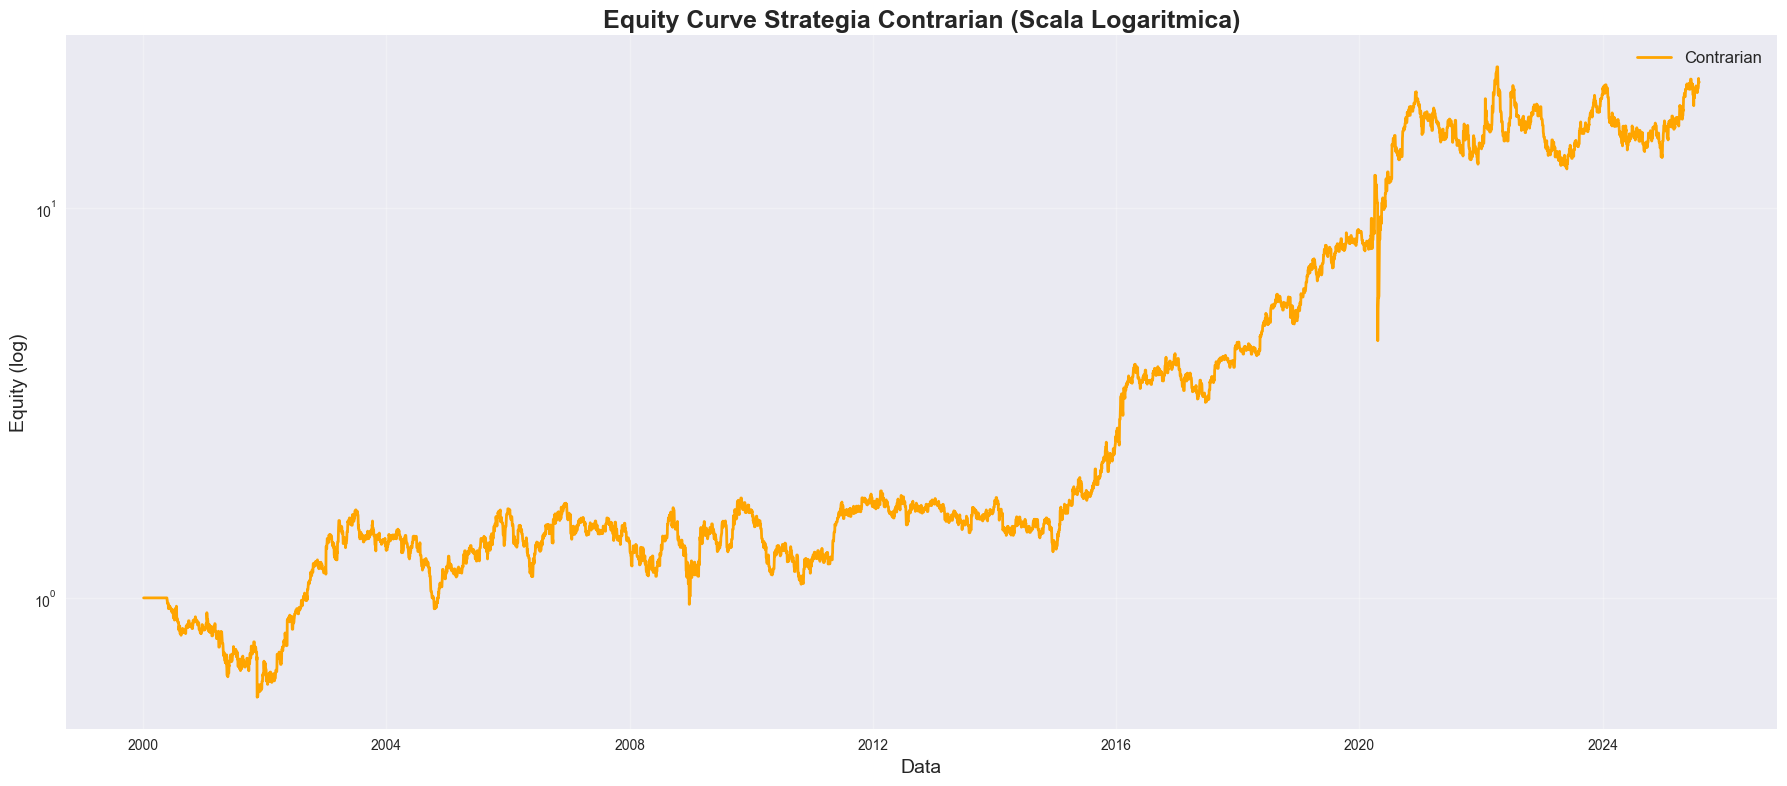

In [10]:
# 📈 Equity Curve Contrarian su Scala Logaritmica (Schermo Intero)
plt.figure(figsize=(18, 8))
plt.plot(equity_contrarian.index, equity_contrarian.values, color='orange', linewidth=2, label='Contrarian')
plt.yscale('log')
plt.title('Equity Curve Strategia Contrarian (Scala Logaritmica)', fontsize=18, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Equity (log)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Top 10 commodities per allocazione media assoluta:


,Commodity,Mean_Absolute_Weight,Mean_Net_Weight
0,NATGAS,0.123941,0.010436
1,LUMBER,0.097489,0.008886
2,LEAN_HOGS,0.096508,0.007491
3,ORANGE_JUICE,0.093976,0.006251
4,SUGAR,0.088241,0.004236
5,PALLADIUM,0.084522,0.004185
6,GASOLINE,0.082920,0.003668
7,COFFEE,0.075635,0.003461
8,OATS,0.072949,0.002996
9,COCOA,0.072277,0.002687


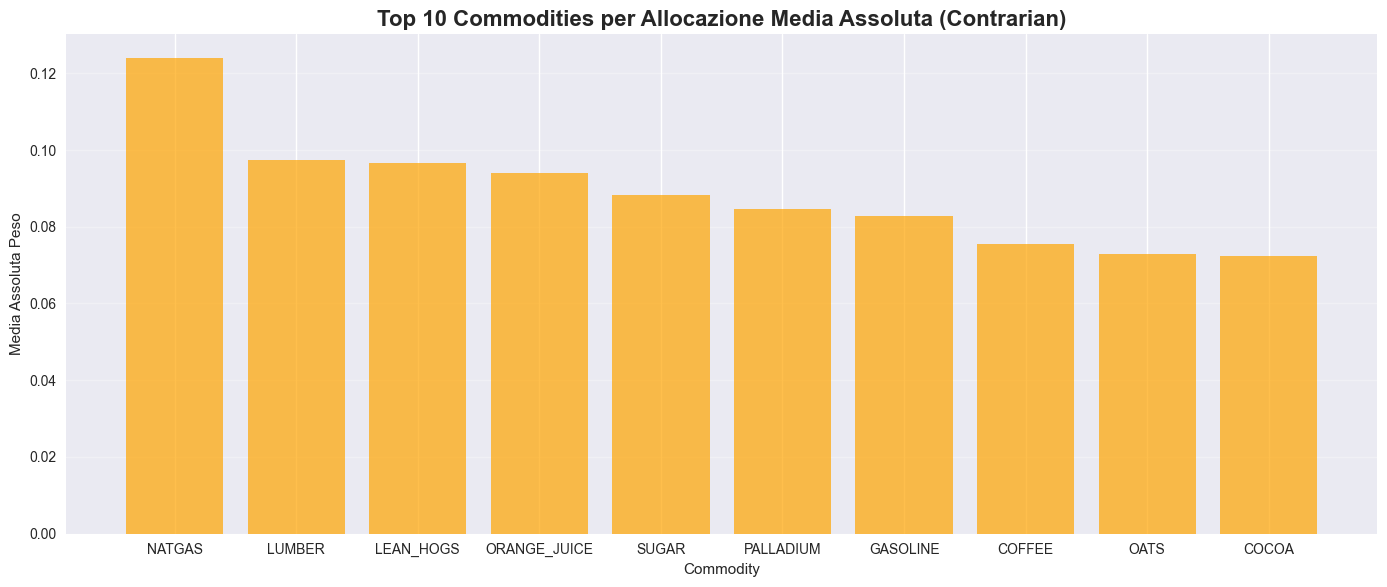

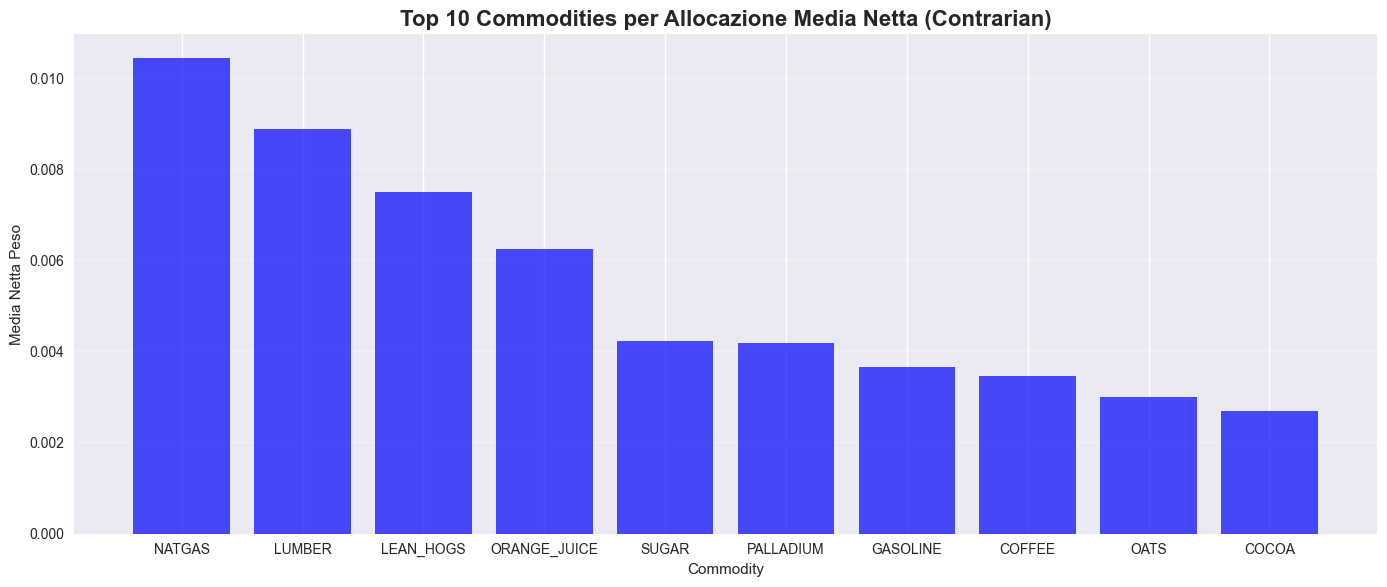

In [11]:
# 🔍 Analisi delle commodities più investite dal portafoglio contrarian

# Calcola la media assoluta e netta dei pesi per ogni commodity
mean_abs_weights = signals_contrarian.abs().mean().sort_values(ascending=False)
mean_net_weights = signals_contrarian.mean().sort_values(ascending=False)

# Estrai i nomi delle commodities (rimuovi '_weight')
commodities = [col.replace('_weight', '') for col in mean_abs_weights.index]

# Crea un DataFrame riepilogativo
alloc_df = pd.DataFrame({
    'Commodity': commodities,
    'Mean_Absolute_Weight': mean_abs_weights.values,
    'Mean_Net_Weight': mean_net_weights.values
})

# Mostra le prime 10 commodities per allocazione media assoluta
print('Top 10 commodities per allocazione media assoluta:')
display(alloc_df.head(10))

# Visualizza le allocazioni in un bar plot
plt.figure(figsize=(14, 6))
plt.bar(alloc_df['Commodity'][:10], alloc_df['Mean_Absolute_Weight'][:10], color='orange', alpha=0.7)
plt.title('Top 10 Commodities per Allocazione Media Assoluta (Contrarian)', fontsize=16, fontweight='bold')
plt.ylabel('Media Assoluta Peso')
plt.xlabel('Commodity')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualizza anche la media netta (long/short prevalente)
plt.figure(figsize=(14, 6))
plt.bar(alloc_df['Commodity'][:10], alloc_df['Mean_Net_Weight'][:10], color='blue', alpha=0.7)
plt.title('Top 10 Commodities per Allocazione Media Netta (Contrarian)', fontsize=16, fontweight='bold')
plt.ylabel('Media Netta Peso')
plt.xlabel('Commodity')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()